In [1]:
from sys import path
path.append("..")

import numpy as np
import networkx as nx
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from rdd import measures
from rdd import RDD
from rdd import visualize
from rdd import other_sims
from rdd import ascos
from rdd import cos_sim
from rdd.utils import df_to_cluster_list
from rdd.other_sims import kmeans2, kmedoid_clustering2, simrank


In [81]:
G1, G2 = nx.Graph(), nx.Graph()

G2.add_edges_from([
    (1,2),
    (2,4),
    (2,3),
    (3,5),
    (4,5),
    (5,6)
])

G1.add_edges_from([
    (1, 2),
    (2, 3),
    (2, 4),
    (3, 4),
    (3, 6),
    (4, 5),
])

G3 = nx.read_adjlist('../data/facebook_combined.txt', nodetype=int)
G4 = nx.read_gml('../data/karate.gml', label='id')

real_paths1 = nx.single_source_shortest_path(G3, 1, 2)
node_list1 = RDD.populate_node_list(real_paths1)
list_of_nodes = []
for node in node_list1:
    list_of_nodes.append(node.name)
G5 = RDD.nodes_to_graph(G3, list_of_nodes)
G6 = nx.read_gml('../data/lesmiserables.gml')

target_G = G6
target_rad = 2
measure_list = measures.global_graph_degree

pos = nx.spring_layout(target_G)

In [82]:
def get_df_for_cluster(g):
    all_rdds_df = pd.DataFrame() 

    for target_one in g.nodes():
        rdd_list = []
        for target_two in g.nodes():
            rdd_list.append(RDD.realworld_distance_compare(target_G, target_one, target_two, measure_list, target_rad))
        all_rdds_df[target_one] = rdd_list
    
    return all_rdds_df



In [83]:
from sklearn_extra.cluster import KMedoids

cluster_df = get_df_for_cluster(target_G)
np_of_rdds = np.array(cluster_df)
kmedoids = KMedoids(n_clusters=2, random_state=0).fit(np_of_rdds)
kmedoids.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0])

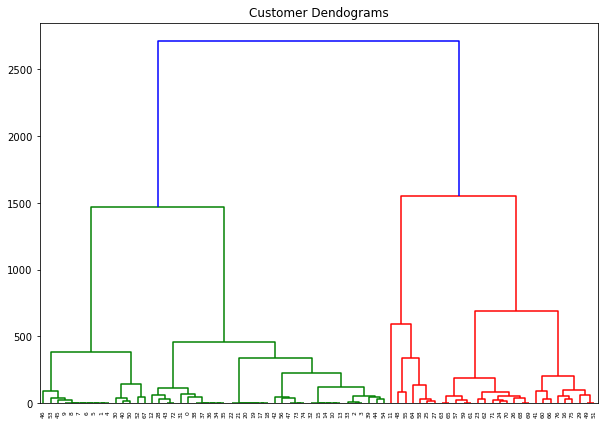

In [84]:
import scipy.cluster.hierarchy as shc

data = get_df_for_cluster(target_G)
plt.figure(figsize=(10, 7))
plt.title("Customer Dendograms")
dend = shc.dendrogram(shc.linkage(data, method='ward'))

In [85]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
cluster.fit_predict(data)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0])

In [86]:
other_sims.agglomerative_hierarchical_clustering(target_G, target_rad, measure_list, 3)

,node_name,radius,degree,cluster
0,Myriel,1,10,0
1,Napoleon,1,1,0
2,MlleBaptistine,1,3,0
3,MmeMagloire,1,3,0
4,CountessDeLo,1,1,0
5,Geborand,1,1,0
6,Champtercier,1,1,0
7,Cravatte,1,1,0
8,Count,1,1,0
9,OldMan,1,1,0


# Clusters based of distance matrixs

In [87]:
tareget_nodes = []
# target_node = 1
target_node = "Valjean"

# fig = visualize.draw(G4, pos)
fig = visualize.visualize_rdd_vector(target_G, target_node, target_rad, pos, [measures.global_graph_degree])
visualize.add_markers(fig, tareget_nodes)
fig.show()

In [88]:
target_clusters = 2
pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_colwidth", 200)

In [89]:
%%timeit -n1 -r1
df = other_sims.kmedoid_clustering2(target_G, RDD.get_rdd_matrix(target_G, target_rad, measures.global_graph_degree), target_clusters)
fig = visualize.visualize_rdd_kmedoid(target_G, target_rad, measure_list, pos, target_clusters)
fig.show()
df = df.sort_values('cluster')
# print(df)1

clusters = df_to_cluster_list(df)
result = nx.algorithms.community.modularity(target_G, clusters)
print(result)


0.14538254076508283
1.81 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [90]:
%%timeit -n1 -r1
df = other_sims.agglomerative_hierarchical_clustering(target_G,target_rad, measures.global_graph_degree, target_clusters)
fig = visualize.visualize_rdd_agglomerative_hierarchical_clustering(target_G, target_rad, measure_list, pos, target_clusters)
fig.show()
df = df.sort_values('cluster')
# print(df)

clusters = df_to_cluster_list(df)
result = nx.algorithms.community.modularity(target_G, clusters)
print(result)

0.15077655155310735
1.75 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [91]:
%%timeit -n1 -r1
df = other_sims.k_means_matrix_clustering(target_G, target_rad, [measures.global_graph_degree], target_clusters)
fig = visualize.visualize_rdd_kmeans_matrix(target_G, target_rad, [measure_list], pos, target_clusters)
fig.show()
df = df.sort_values('cluster')
# print(df)

clusters = df_to_cluster_list(df)
result = nx.algorithms.community.modularity(target_G, clusters)
print(result)


0.14519654039308205
1.8 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [92]:
for k in range(1, 10, 1):
    df = other_sims.kmedoid_clustering2(target_G, RDD.get_rdd_matrix(target_G, target_rad, measures.global_graph_degree), k)
    df = df.sort_values('cluster')
    clusters = df_to_cluster_list(df)
    result = nx.algorithms.community.modularity(target_G, clusters)
    print(result)


1.2421712827191405e-16
0.14538254076508283
0.14232128464256918
0.13118451236902537
0.11724998449996982
0.13485801971603914
0.13268026536053096
0.13514477028954072
0.1351447702895407


# Clustoring on a list of rdds obtained from single root node (target_node = 1) to all others

In [73]:
%%timeit -n1 -r1
df = RDD.get_rdds_for_visuals_vector(target_G, target_node, [measures.global_graph_degree], target_rad)
df = other_sims.k_means(df, [measures.global_graph_degree], target_clusters)
fig = visualize.visualize_rdd_vector_kmeans(target_G, target_node, target_rad, [measure_list], pos, target_clusters)
fig.show()
df = df.sort_values('cluster')
#print(df)

clusters = df_to_cluster_list(df)
result = nx.algorithms.community.modularity(target_G, clusters)
print(result)


0.13423026846054137
153 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [74]:
%%timeit -n1 -r1
df = RDD.get_rdds_for_visuals_vector(target_G, target_node, [measures.global_graph_degree], target_rad)
df = other_sims.mean_shift(df, [measures.global_graph_degree])
fig = visualize.visualize_rdd_vector_mean_shift(target_G, target_node,target_rad, [measure_list], pos)
fig.show()
df = df.sort_values('cluster')
#print(df)

clusters = df_to_cluster_list(df)
result = nx.algorithms.community.modularity(target_G, clusters)
print(result)

0.09134943269886472
281 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


# ASCOS TESTS

In [75]:
nodes, sims = ascos.ascos(target_G)
df = other_sims.k_means_matrix(target_G, sims, target_clusters)
df = df.sort_values('cluster')
#print(df)

clusters = df_to_cluster_list(df)
result = nx.algorithms.community.modularity(target_G, clusters)
print(result)

0.07464039928079776


In [76]:
nodes, sims = ascos.ascos(target_G)
df = other_sims.kmedoid_clustering2(target_G, sims, target_clusters)
df = df.sort_values('cluster')
#print(df)

clusters = df_to_cluster_list(df)
result = nx.algorithms.community.modularity(target_G, clusters)
print(result)

0.20100440200880418


In [77]:
sims = cos_sim.cosine(target_G)
print(sims)

# all_cos_df = pd.DataFrame() 
# for node in target_G:
#     list_of_cos = []
#     for node2 in target_G:
#         list_of_cos.append(sims[node][node2])
#     all_cos_df[node] = list_of_cos

print(sims['Myriel'])
    

{'Myriel': {'MmeMagloire': 0.15384615384615385, 'Valjean': 0.043478260869565216, 'MlleBaptistine': 0.15384615384615385, 'Labarre': 0.09090909090909091, 'Marguerite': 0.08333333333333333, 'MmeDeR': 0.09090909090909091, 'Isabeau': 0.09090909090909091, 'Gervais': 0.09090909090909091, 'Fantine': 0.04, 'MmeThenardier': 0.047619047619047616, 'Thenardier': 0.038461538461538464, 'Cosette': 0.047619047619047616, 'Javert': 0.037037037037037035, 'Fauchelevent': 0.07142857142857142, 'Bamatabois': 0.05555555555555555, 'Simplice': 0.07142857142857142, 'Scaufflaire': 0.09090909090909091, 'Woman1': 0.08333333333333333, 'Judge': 0.0625, 'Champmathieu': 0.0625, 'Brevet': 0.0625, 'Chenildieu': 0.0625, 'Cochepaille': 0.0625, 'Woman2': 0.07692307692307693, 'MotherInnocent': 0.08333333333333333, 'Gavroche': 0.03125, 'Gillenormand': 0.058823529411764705, 'MlleGillenormand': 0.058823529411764705, 'Marius': 0.034482758620689655, 'Enjolras': 0.04, 'Bossuet': 0.043478260869565216, 'Gueulemer': 0.05, 'Babet': 0.0

In [78]:
# SimRank Modularity test with KMeans_Matrix
sim = nx.simrank_similarity(target_G)
df = pd.DataFrame.from_records(sim)

all_sim_df = pd.DataFrame() 
for node in target_G:
    list_of_sim = []
    for node2 in target_G:
        list_of_sim.append(sim[node][node2])
    all_sim_df[node] = list_of_sim

df = other_sims.k_means_matrix(target_G, all_sim_df, target_clusters)
df = df.sort_values('cluster')
#print(df)

clusters = df_to_cluster_list(df)
result = nx.algorithms.community.modularity(target_G, clusters)
print(result)

-0.000379750759501537


In [79]:
sim = nx.simrank_similarity(target_G)
df = pd.DataFrame.from_records(sim)

all_sim_df = pd.DataFrame() 
for node in target_G:
    list_of_sim = []
    for node2 in target_G:
        list_of_sim.append(sim[node][node2])
    all_sim_df[node] = list_of_sim

df = other_sims.kmedoid_clustering2(target_G, all_sim_df, target_clusters)
df = df.sort_values('cluster')
#print(df)

clusters = df_to_cluster_list(df)
result = nx.algorithms.community.modularity(target_G, clusters)
print(result)

-0.0009377518755038661
